# US Health Insurance
Data Source: https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset

**Machine Learning Project Checklist (from the book Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow):**
1. Frame the problem and look at the big picture.
2. Get the data.
3. Explore the data to gain insights.
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
5. Explore many different models and shortlist the best ones.
6. Fine-tune your models and combine them into a great solution.
7. Present your solution.
8. Launch, monitor, and maintain your system.

So, we will go through the same process:

## 1. Frame the problem and look at the big picture
This dataset contains 1338 rows of insured data, where the Insurance charges are given against the following attributes of the insured: Age, Sex, BMI, Number of Children, Smoker and Region. There are no missing or undefined values in the dataset.


**Goal: To create machine learning models to predict the insurance charge based on the described features.**

My porposed solution has the following properties:
* Supervised Learning
* Offline Learning (because it is a training project)
* Performance Measure: Root Mean Square Error (RMSE), since we don't have a lot of outliers in the data

## 2. Get the data

In [1]:
import pandas as pd

dataset = pd.read_csv('dataset.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**Notes:**
* There is no nonsensical feature to drop.
* Sex, smoker, and region should be one-hot encoded.
* Charges is target.
* There is no missed value.

### Split data and target

In [2]:
X = dataset.drop(['charges'], axis=1)
y = dataset['charges'].copy()

### Split train data and test data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 3. Explore the data to gain insights

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003 entries, 693 to 1126
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1003 non-null   int64  
 1   sex       1003 non-null   object 
 2   bmi       1003 non-null   float64
 3   children  1003 non-null   int64  
 4   smoker    1003 non-null   object 
 5   region    1003 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 54.9+ KB


In [5]:
X_train.describe()

,age,bmi,children
count,1003.000000,1003.000000,1003.000000
mean,39.255234,30.511780,1.104686
std,14.039105,6.013107,1.204619
min,18.000000,15.960000,0.000000
25%,27.000000,26.210000,0.000000
50%,39.000000,30.200000,1.000000
75%,51.000000,34.430000,2.000000
max,64.000000,53.130000,5.000000


In [6]:
for feature in ['sex', 'region', 'smoker']:
    print(f'Ratio of {feature.capitalize()} (in percentage):')
    print(X_train[feature].value_counts() * 100 / len(X_train))
    print('\n-------------------\n')

Ratio of Sex (in percentage):
male      50.448654
female    49.551346
Name: sex, dtype: float64

-------------------

Ratio of Region (in percentage):
southeast    25.822532
northeast    25.024925
southwest    24.626122
northwest    24.526421
Name: region, dtype: float64

-------------------

Ratio of Smoker (in percentage):
no     79.461615
yes    20.538385
Name: smoker, dtype: float64

-------------------



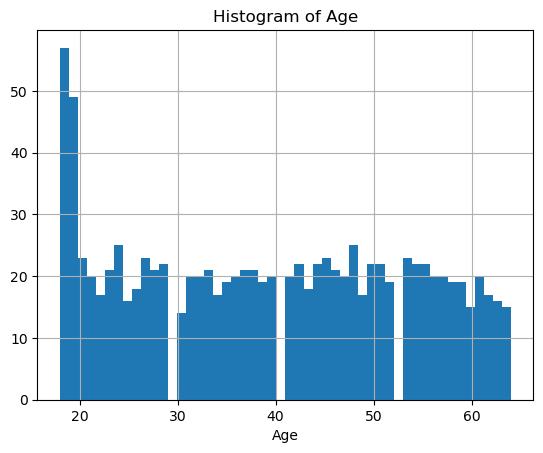

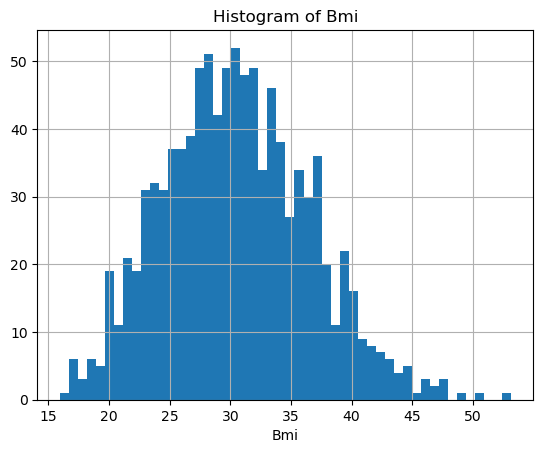

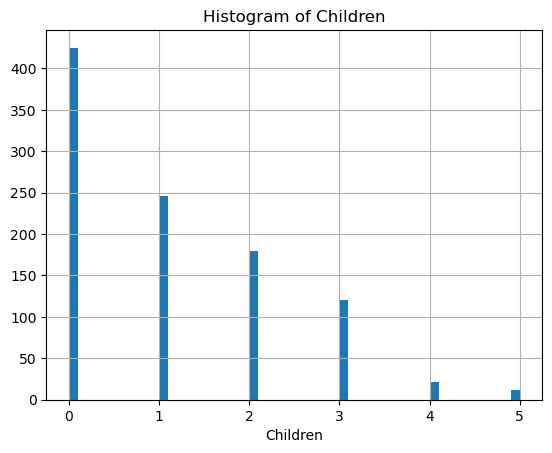

In [7]:
import matplotlib.pyplot as plt

for feature in ['age', 'bmi', 'children']:
    plt.hist(X_train[feature], bins=50)
    plt.title(f'Histogram of {feature.capitalize()}')
    plt.grid()
    plt.xlabel(feature.capitalize())
    plt.show()

We can conclude that:

> **The number of children is higher** \
> **Males and females are distributed equally**\
> **Nearly 20 percent are smoker**\
> **Equal distribution in each region**\
> **BMI follow the Gaussian distribution.**

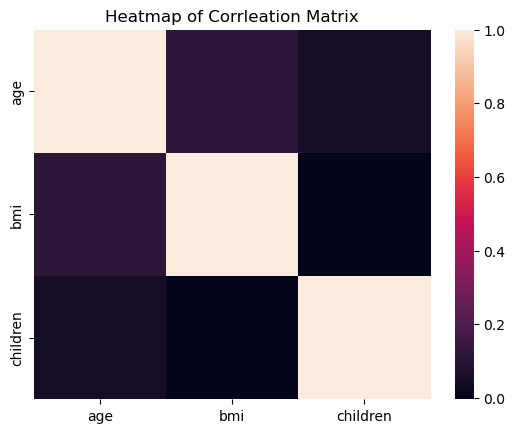

In [8]:
import seaborn as sns

sns.heatmap(X_train.drop(['sex', 'smoker', 'region'], axis=1).corr())
plt.title('Heatmap of Corrleation Matrix')
plt.show()

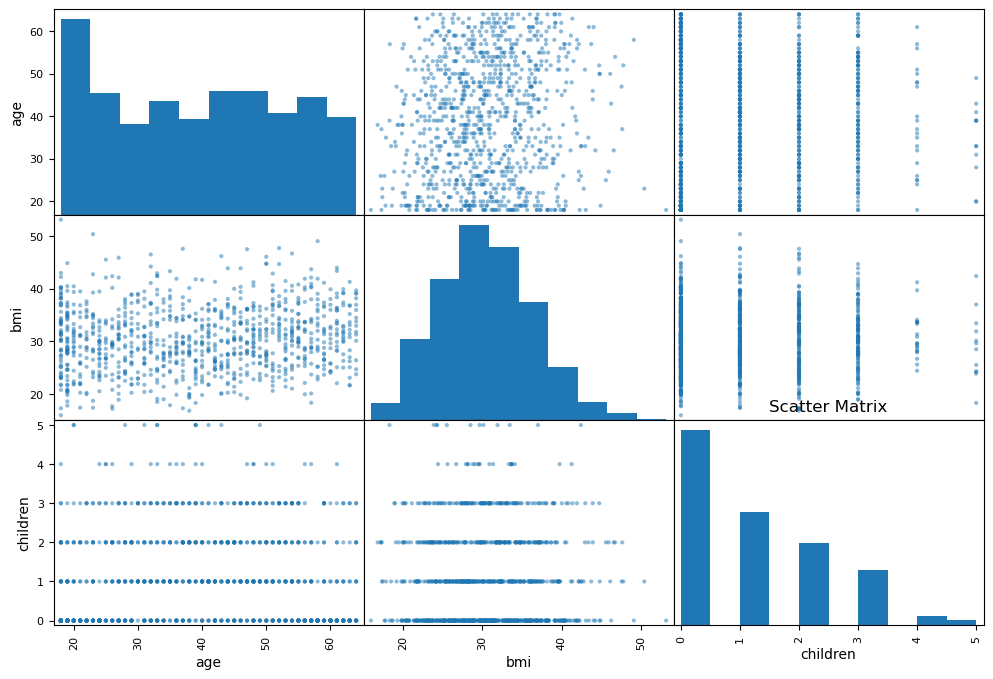

In [9]:
from pandas.plotting import scatter_matrix

scatter_matrix(X_train, figsize=(12, 8))
plt.title('Scatter Matrix')
plt.show()

## 4. Data Prepration

Transformers to apply:
* Encode Categorical Features
* Feature Scaling for Numerical Features


In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numericalCols = ['age', 'bmi', 'children']
categoricalCols = ['sex', 'smoker', 'region']

fullPipeline = ColumnTransformer([
    ('num', StandardScaler(), numericalCols),
    ('cat', OneHotEncoder(), categoricalCols)
])

X_train_prepared = fullPipeline.fit_transform(X_train)
X_test_prepared = fullPipeline.transform(X_test)

## 5. Explore many different models and shortlist the best ones.
Usually for tabular datasets, enseble learning models such as random forest work well, But other models should be examined also.

Frist, let's look at some statistic about the target y_train:

In [11]:
y_train.describe()

count     1003.000000
mean     13267.935817
std      12051.356547
min       1121.873900
25%       4780.839400
50%       9447.382400
75%      16840.667970
max      62592.873090
Name: charges, dtype: float64

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluateModel(model, X, y, n_cross_validation=10):
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse_seen = np.sqrt(mse)
    scores_unseen = cross_val_score(model, X, y, 
                                    scoring='neg_mean_squared_error', 
                                    cv=n_cross_validation)
    rmse_unseen = np.sqrt(-scores_unseen)
    print('Mean RMSE on Seen Data: {}'.format(rmse_seen.mean()))
    print('Standard Deviation RMSE on Seen Data: {}'.format(rmse_seen.std()))
    print('-'*20)
    print('Mean RMSE on Unseen Data: {}'.format(rmse_unseen.mean()))
    print('Standard Deviation RMSE on Unseen Data: {}'.format(rmse_unseen.std()))

In [13]:
# Evaluate Linear Regression Model:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
evaluateModel(lin_reg, X_train_prepared, y_train)

Mean RMSE on Seen Data: 6083.132596294014
Standard Deviation RMSE on Seen Data: 0.0
--------------------
Mean RMSE on Seen Data: 6114.109519605432
Standard Deviation RMSE on Seen Data: 443.2882924696095


By comparing the RMSE, the model performs poorly.

In [14]:
# Evaluate Decition Tree Regression Model:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
evaluateModel(tree_reg, X_train_prepared, y_train)

Mean RMSE on Seen Data: 427.37357318969015
Standard Deviation RMSE on Seen Data: 0.0
--------------------
Mean RMSE on Seen Data: 6440.96169597005
Standard Deviation RMSE on Seen Data: 784.3878372916445


In [15]:
# Evaluating Support Vector Machine Model:
from sklearn.svm import SVR

svm_reg = SVR()
evaluateModel(svm_reg, X_train_prepared, y_train)

Mean RMSE on Seen Data: 12618.039329088191
Standard Deviation RMSE on Seen Data: 0.0
--------------------
Mean RMSE on Seen Data: 12583.677540516499
Standard Deviation RMSE on Seen Data: 987.5363303665576


In [16]:
# Evaluate Random Forest Regression Model:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
evaluateModel(forest_reg, X_train_prepared, y_train)

Mean RMSE on Seen Data: 1887.5691260152753
Standard Deviation RMSE on Seen Data: 0.0
--------------------
Mean RMSE on Seen Data: 4876.958206433719
Standard Deviation RMSE on Seen Data: 586.4447523251388


Eventhough the model overfit the training set, it works way better than linear regression

In [17]:
# Evaluate XGBoost Regressor Model:
from sklearn.ensemble import GradientBoostingRegressor

xgboost_reg = GradientBoostingRegressor()
evaluateModel(xgboost_reg, X_train_prepared, y_train)

Mean RMSE on Seen Data: 3685.35711337744
Standard Deviation RMSE on Seen Data: 0.0
--------------------
Mean RMSE on Seen Data: 4576.078557531075
Standard Deviation RMSE on Seen Data: 661.809579064982


## 6. Fine-tune your models
From the previous section we can realize thet RandomForestRegressor and GradientBoostingRegressor gives the best performance among examined models. 
So, we start fine-tuning these two models:

### Fine-tune for RandomForestRegressor()

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [100, 120, 140], 'max_features': [6, 7, 8, 9], 'max_depth': [3, 4, 5, 6]}
]

forest_reg = RandomForestRegressor()
grid_search_forest = GridSearchCV(forest_reg, param_grid,
                           cv=10, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search_forest.fit(X_train_prepared, y_train)
print(grid_search_forest.best_params_)

{'max_depth': 5, 'max_features': 8, 'n_estimators': 100}


In [69]:
cvResults = grid_search_forest.cv_results_
for mean_score, params in zip(cvResults['mean_test_score'], cvResults['params']):
    print(np.sqrt(-mean_score), params)

4815.492798787461 {'max_depth': 3, 'max_features': 6, 'n_estimators': 100}
4851.816934608883 {'max_depth': 3, 'max_features': 6, 'n_estimators': 120}
4845.913011991626 {'max_depth': 3, 'max_features': 6, 'n_estimators': 140}
4722.675251895397 {'max_depth': 3, 'max_features': 7, 'n_estimators': 100}
4744.394783014819 {'max_depth': 3, 'max_features': 7, 'n_estimators': 120}
4727.541134267354 {'max_depth': 3, 'max_features': 7, 'n_estimators': 140}
4644.916088130856 {'max_depth': 3, 'max_features': 8, 'n_estimators': 100}
4644.515724854226 {'max_depth': 3, 'max_features': 8, 'n_estimators': 120}
4652.343479423173 {'max_depth': 3, 'max_features': 8, 'n_estimators': 140}
4622.0977119184345 {'max_depth': 3, 'max_features': 9, 'n_estimators': 100}
4619.567131796526 {'max_depth': 3, 'max_features': 9, 'n_estimators': 120}
4602.2445106941295 {'max_depth': 3, 'max_features': 9, 'n_estimators': 140}
4624.909846565295 {'max_depth': 4, 'max_features': 6, 'n_estimators': 100}
4631.902697094253 {'max

In [72]:
finalModelForest = grid_search_forest.best_estimator_
print('Feature Importances:', finalModel.feature_importances_)

Feature Importances: [0.12310017 0.16132759 0.0092651  0.000887   0.00101293 0.35638157
 0.34178339 0.00221305 0.00087974 0.00205784 0.00109161]


### Fine-tune for GradientBoostingRegressor()

In [54]:
param_grid = [
    {'n_estimators': [120, 130], 'max_features': [7, 8, 9], 'max_depth': [2, 3, 4]}
]

xgboost_reg = GradientBoostingRegressor()
grid_search_xgboost = GridSearchCV(xgboost_reg, param_grid, 
                           cv=10, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search_xgboost.fit(X_train_prepared, y_train)
print(grid_search_xgboost.best_params_)

{'max_depth': 2, 'max_features': 7, 'n_estimators': 130}


In [55]:
cvResults = grid_search_xgboost.cv_results_
for mean_score, params in zip(cvResults['mean_test_score'], cvResults['params']):
    print(np.sqrt(-mean_score), params)

4500.524300247642 {'max_depth': 2, 'max_features': 7, 'n_estimators': 120}
4487.855660229563 {'max_depth': 2, 'max_features': 7, 'n_estimators': 130}
4525.457143081597 {'max_depth': 2, 'max_features': 8, 'n_estimators': 120}
4520.378487016683 {'max_depth': 2, 'max_features': 8, 'n_estimators': 130}
4498.184506162142 {'max_depth': 2, 'max_features': 9, 'n_estimators': 120}
4495.877741620477 {'max_depth': 2, 'max_features': 9, 'n_estimators': 130}
4606.15781147063 {'max_depth': 3, 'max_features': 7, 'n_estimators': 120}
4610.551328278568 {'max_depth': 3, 'max_features': 7, 'n_estimators': 130}
4626.6804533545555 {'max_depth': 3, 'max_features': 8, 'n_estimators': 120}
4635.131136501392 {'max_depth': 3, 'max_features': 8, 'n_estimators': 130}
4618.00961806951 {'max_depth': 3, 'max_features': 9, 'n_estimators': 120}
4666.539654868775 {'max_depth': 3, 'max_features': 9, 'n_estimators': 130}
4761.259694208172 {'max_depth': 4, 'max_features': 7, 'n_estimators': 120}
4776.766620819961 {'max_de

In [70]:
finalModelXGBoost = grid_search_xgboost.best_estimator_
print('Feature Importances:', finalModel.feature_importances_)

Feature Importances: [0.12310017 0.16132759 0.0092651  0.000887   0.00101293 0.35638157
 0.34178339 0.00221305 0.00087974 0.00205784 0.00109161]


# **Evaluate Your Model on the Test Set**

In [73]:
y_test_pred = finalModelForest.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
print('RMSE ON TEST SET FOR RANODM FOREST: {}'.format(rmse))

RMSE ON TEST SET FOR RANODM FOREST: 4527.218927360192


In [74]:
y_test_pred = finalModelXGBoost.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
print('RMSE ON TEST SET FOR XGBOOST: {}'.format(rmse))

RMSE ON TEST SET FOR XGBOOST: 4513.934884716888
